In [16]:
%load_ext autoreload
%autoreload 2

import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from go_bench.metrics import threshold_stats

train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
# test_dataset = BertSeqDataset.from_memory("data/go_bench/testing_molecular_function_annotations.tsv", 
#                                             "data/go_bench/testing_molecular_function_terms.json", 
#                                             "data/uniprot_reviewed.fasta")
# test_dataset.to_pickle(f"{train_path}/test.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

_, val_ids, _, val_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/validation_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}
# from qtlsearch.OBOParser import OBO
# go = OBO('/home/andrew/GO_benchmarking/data/go.obo.gz', store_as_int=True)
test_ia = np.zeros(len(test_go_terms))
for i, test_id in enumerate(test_go_terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
print(go_terms)

['GO:0003674', 'GO:0005488', 'GO:0003824', 'GO:0005515', 'GO:0097159', 'GO:1901363', 'GO:0016740', 'GO:0003676', 'GO:0016787', 'GO:0140096', 'GO:0043167', 'GO:0003677', 'GO:0016491', 'GO:0003723', 'GO:0005215', 'GO:0140110', 'GO:0042802', 'GO:0022857', 'GO:0016772', 'GO:0043565', 'GO:0036094', 'GO:0003690', 'GO:0098772', 'GO:0043169', 'GO:0043168', 'GO:1990837', 'GO:0003700', 'GO:0019899', 'GO:0046872', 'GO:0140640', 'GO:0001067', 'GO:0000976', 'GO:0016788', 'GO:0016301', 'GO:1901265', 'GO:0000166', 'GO:0044877', 'GO:0005102', 'GO:0015075', 'GO:0097367', 'GO:0005198', 'GO:0016773', 'GO:0000977', 'GO:0060089', 'GO:0000981', 'GO:0038023', 'GO:0140098', 'GO:0030234', 'GO:0015318', 'GO:0000987', 'GO:0000978', 'GO:0032553', 'GO:0008324', 'GO:0017076', 'GO:0046983', 'GO:0032555', 'GO:0008092', 'GO:0046914', 'GO:0004888', 'GO:0022890', 'GO:0003735', 'GO:0022804', 'GO:0008233', 'GO:0004672', 'GO:0035639', 'GO:0140657', 'GO:0042803', 'GO:0016829', 'GO:0008289', 'GO:0016874', 'GO:0030554', 'GO:0

In [3]:
model_probs = {}
import pickle
with open("paper_result_predictions/blast.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BLAST"] = probs
with open("paper_result_predictions/conv128.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv128"] = probs
with open("paper_result_predictions/conv2048.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv2048"] = probs
with open("paper_result_predictions/conv128_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv128-Emb"] = probs
with open("paper_result_predictions/conv2048_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["Conv2048-Emb"] = probs
with open("paper_result_predictions/bert_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-Emb"] = probs
with open("paper_result_predictions/bert_finetune.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-FT"] = probs
with open("paper_result_predictions/bert_finetune_emb.pkl", "rb") as f:
    probs = pickle.load(f)['probs']
    model_probs["BERT-FT-Emb"] = probs

In [4]:
from qtlsearch.OBOParser import OBO
go = OBO('data/go.obo', store_as_int=True)

# general_terms = ['GO:0022804', 'GO:0016491', 'GO:0022803', 
#                   'GO:0000166', 'GO:0015075', 'GO:0016772', 'GO:0043167']
# general_term_names = [go[int(term[3:])].name for term in general_terms]
# general_term_idx = [go_terms.index(term) for term in general_terms]

In [18]:
term_frequencies = train_labels.toarray().sum(axis=0)
ct = [(f, g) for f, g in zip(term_frequencies, go_terms) if f > 0]
# print(ct)
random_terms = ['GO:0008022', 'GO:0019903', 'GO:0000149', 'GO:0004197', 'GO:0030145', 'GO:0004601', 'GO:0003730', 'GO:0019838']
random_term_names = [go[int(term[3:])].name for term in random_terms]
random_term_idx = [go_terms.index(term) for term in random_terms]

In [19]:
selected_terms = ['GO:0022804', 'GO:0016491', 'GO:0022803', 
                  'GO:0000166', 'GO:0030145', 'GO:0004601', 'GO:0003730', 'GO:0019838']

In [7]:
from sklearn.metrics import precision_recall_fscore_support
model_stats = {}
for mn in model_probs.keys():
    preds = model_probs[mn] > 0.5
    model_stats[mn] = precision_recall_fscore_support(test_labels, preds)

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
# blast_f1, emb_f1 = [], []
# for threshold in np.linspace(0, 1, 15):
#     _, _, f1, _ = precision_recall_fscore_support(test_labels, model_probs['BLAST'] > threshold)
#     _, _, ef1, _ = precision_recall_fscore_support(test_labels, model_probs['BERT-FT-Emb'] > threshold)
#     blast_f1.append(f1[[1, 100, 110, 120]])
#     emb_f1.append(ef1[[1, 100, 110, 120]])

# plt.plot(np.linspace(0, 1, 15), blast_f1, c='orange')
# plt.plot(np.linspace(0, 1, 15), emb_f1, c='blue')

# plt.legend(['BLAST', 'BERT-FT-Emb'])
# plt.show()

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

In [10]:
bprec, brec, bf, bs = model_stats['BLAST']
fprec, frec, ftf, fs = model_stats['BERT-FT-Emb']

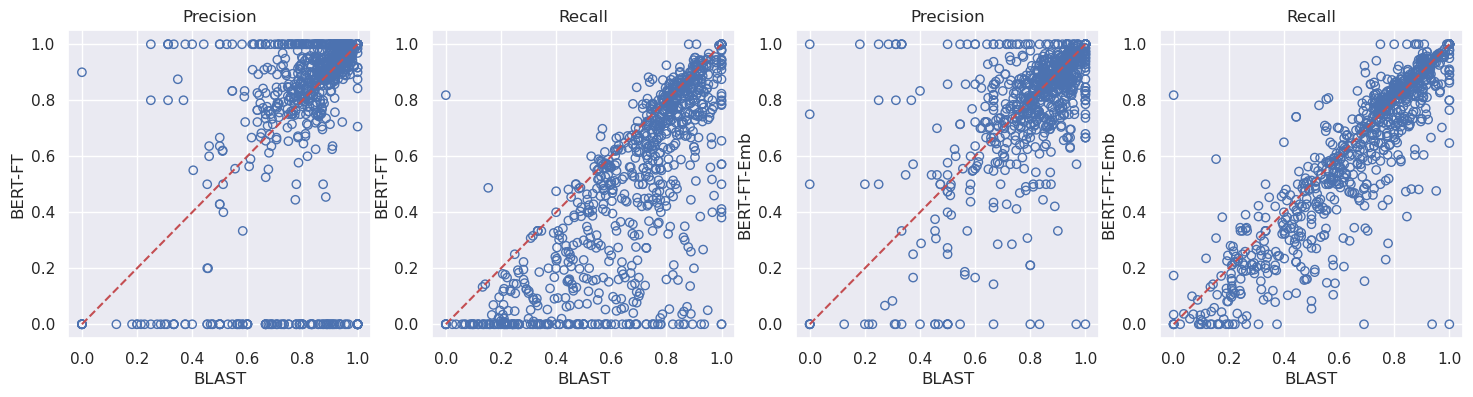

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
axes[0].scatter(model_stats['BLAST'][0], model_stats['BERT-FT'][0], facecolors='none', edgecolors='b')
axes[0].plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), '--', c='r')
axes[0].set_title("Precision")
axes[0].set_xlabel("BLAST")
axes[0].set_ylabel("BERT-FT")

axes[1].scatter(model_stats['BLAST'][1], model_stats['BERT-FT'][1], facecolors='none', edgecolors='b')
axes[1].plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), '--', c='r')
axes[1].set_title("Recall")
axes[1].set_xlabel("BLAST")
axes[1].set_ylabel("BERT-FT")

axes[2].scatter(model_stats['BLAST'][0], model_stats['BERT-FT-Emb'][0], facecolors='none', edgecolors='b')
axes[2].plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), '--', c='r')
axes[2].set_title("Precision")
axes[2].set_xlabel("BLAST")
axes[2].set_ylabel("BERT-FT-Emb")

axes[3].scatter(model_stats['BLAST'][1], model_stats['BERT-FT-Emb'][1], facecolors='none', edgecolors='b')
axes[3].plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), '--', c='r')
axes[3].set_title("Recall")
axes[3].set_xlabel("BLAST")
axes[3].set_ylabel("BERT-FT-Emb")

plt.show()

In [12]:
label_names = ['Active Transmembrane\nTransport', 'Oxidoreductase', 
               'Passive Transmembrane\nTransport', 'Nucleotide Binding', 
               'Manganese Ion\nBinding', 'Peroxidase Activity', 
               "mRNA 3'-UTR\nBinding", 'Growth Factor\nBinding']


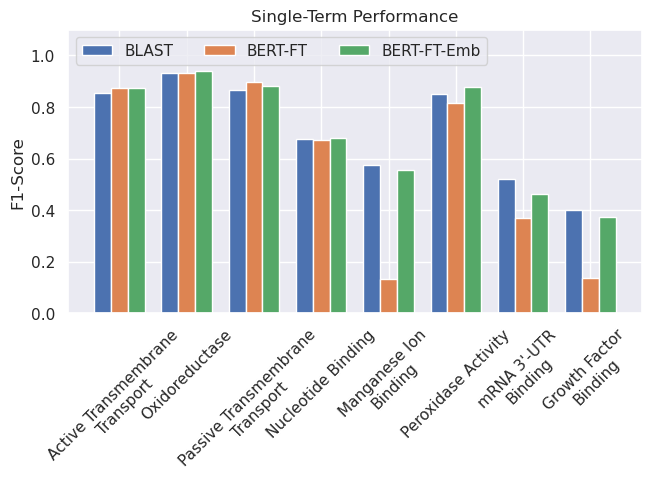

In [13]:
eval_models = ['BLAST', 'BERT-FT', 'BERT-FT-Emb']

terms = selected_terms
term_names = [go[int(term[3:])].name for term in terms]
term_idx = [go_terms.index(term) for term in terms]

x = np.arange(len(terms))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for mn in eval_models:
    prec, rec, fs, supp = model_stats[mn]

    selected_fs = fs[term_idx]

    offset = width * multiplier
    rects = ax.bar(x + offset, selected_fs, width, label=mn)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Single-Term Performance')

ax.set_xticks(x + width, label_names, rotation=45)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.1)
plt.show()

In [14]:
term_frequencies = train_labels.toarray().sum(axis=0)
ct = [(f, g) for f, g in zip(term_frequencies, go_terms) if f < 150]
print(len(ct))

for term in selected_terms:
    print(go[int(term[3:])])

361
GO:0022804
GO:0016491
GO:0022803
GO:0000166
GO:0030145
GO:0004601
GO:0003730
GO:0019838


In [15]:
def kernel_average(x, y, sigma):
    si = np.argsort(x)
    x = x[si]; y = y[si]
    pd = x.reshape((-1, 1)) - x.reshape((1, -1))
    km = np.exp((-pd**2 )/(2*sigma))
    km_sum = km.sum(axis=1, keepdims=True)
    km /= km_sum
    wy = km @ y
    return x, y, km

x, wy, km = kernel_average(fscore, term_frequencies, 0.5)
plt.plot(x, wy)
plt.show()

NameError: name 'fscore' is not defined

/home/andrew/anaconda3/envs/research/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(-10.0, 5000.0)

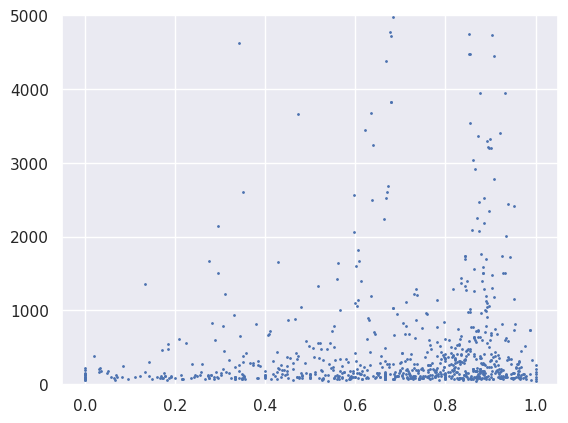

In [ ]:
blast_preds = model_probs['BERT-FT-Emb']
prec, rec, fscore, support = precision_recall_fscore_support(test_labels, blast_preds > 0.5)

plt.scatter(fscore, term_frequencies, s=1)
plt.ylim([-10, 5000])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
tid = go_terms.index('GO:0008139')
term_labels = test_labels.toarray()[:, tid]

In [ ]:
for model_name, preds in model_probs.items():
    prec, rec, fscore, support = precision_recall_fscore_support(term_labels.astype(int), preds.toarray()[:, tid] > 0.2)
    print(model_name, prec, rec, fscore)

BLAST [0.99968151 1.        ] [1.         0.64705882] [0.99984073 0.78571429]
Conv128 [0.99968144 0.73333333] [0.99978761 0.64705882] [0.99973452 0.6875    ]
Conv2048 [0.99962845 1.        ] [1.         0.58823529] [0.99981419 0.74074074]
Conv128-Emb [0.99968151 1.        ] [1.         0.64705882] [0.99984073 0.78571429]
Conv2048-Emb [0.9994693 1.       ] [1.         0.41176471] [0.99973458 0.58333333]
BERT-Emb [0.99973438 0.46153846] [0.99925662 0.70588235] [0.99949545 0.55813953]
BERT-FT [0.99973458 1.        ] [1.         0.70588235] [0.99986727 0.82758621]
BERT-FT-Emb [0.99973448 0.63157895] [0.99962831 0.70588235] [0.99968139 0.66666667]


In [27]:
import pickle
# with open("emb/finetune_train_emb.pkl", "rb") as f:
#     emb_dict = pickle.load(f)
#     train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

# with open("emb/finetune_val_emb.pkl", "rb") as f:
#     emb_dict = pickle.load(f)
#     val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    _, rostlab_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/finetune_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    _, finetune_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/conv128_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    _, conv128_embeddings = emb_dict['prot_id'], emb_dict['embedding']



In [28]:
from sklearn.manifold import TSNE
rostlab_ld = TSNE().fit_transform(rostlab_embeddings)
finetune_ld = TSNE().fit_transform(finetune_embeddings)
conv128_ld = TSNE().fit_transform(conv128_embeddings)

In [29]:
test_labels
test_strs = [" ".join([str(x) for x in row.nonzero()[1]]) for row in test_labels]

In [30]:
label_mat = test_labels.toarray()
label_ld = TSNE().fit_transform(label_mat)

In [ ]:
# from sklearn.decomposition import PCA
# label_pca = PCA(n_components=3).fit_transform(label_mat)
# label_line = TSNE(n_components=1).fit_transform(label_mat)

# import matplotlib as mpl
# cm = mpl.colormaps['tab20c']
# label_c = cm(label_line[:, 0] % 1)

# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(1, 4, figsize=(14, 4))
# axes[0].scatter(rostlab_ld[:, 0], rostlab_ld[:, 1], s=0.1, c=label_c)
# axes[0].set_title("BERT-Pretrain")
# axes[1].scatter(finetune_ld[:, 0], finetune_ld[:, 1], s=0.1, c=label_c)
# axes[1].set_title("BERT-Finetune")
# axes[2].scatter(conv128_ld[:, 0], conv128_ld[:, 1], s=0.1, c=label_c)
# axes[2].set_title("Conv128")
# axes[3].scatter(label_ld[:, 0], label_ld[:, 1], s=0.1, c=label_c)
# axes[3].set_title("Multilabel")
# for ax in axes:
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
# plt.show()


In [24]:
selected_terms = ['GO:0022804', 'GO:0016491', 'GO:0022803', 
                  'GO:0000166', 'GO:0015075', 'GO:0016772', 'GO:0043167']
# selected_terms = ['GO:1901363', 'GO:0016740', 'GO:0022803', 'GO:0000166', 'GO:0016772']
# selected_terms = []
selected_term_namesa = [go[int(term[3:])].name for term in selected_terms]
selected_term_names = ['Active Transmembrane Transporter Activity', 'Oxidoreductase Activity', 
                       'Passive Transmembrane\nTransporter Activity', 'Nucleotide Binding', 
                       'Ion Transmembrane Transporter Activity',
                       'Transferring Phosphorus-\nContaining Groups', 'Ion Binding']

print(len(selected_term_names))
for i, n in enumerate(selected_term_names):
    print(i, n)

7
0 Active Transmembrane Transporter Activity
1 Oxidoreductase Activity
2 Passive Transmembrane
Transporter Activity
3 Nucleotide Binding
4 Ion Transmembrane Transporter Activity
5 Transferring Phosphorus-
Containing Groups
6 Ion Binding


In [25]:
print(len(selected_terms))
selected_term_names = [go[int(term[3:])].name for term in selected_terms]
print(len(selected_term_names))

7
7


In [31]:
import matplotlib as mpl
# cluster_cm = mpl.colormaps['viridis']
cluster_cm = mpl.colormaps['Set2']
color_list = [cluster_cm(i / 8) for i in range(len(selected_term_names))]

tcm = {t:i for i, t in enumerate(go_terms)}
selected_term_indices = [tcm[t] for t in selected_terms]
covered = (label_mat[:, selected_term_indices].sum(axis=1) > 0) # & (label_mat[:, selected_term_indices].sum(axis=1) <= 1)
sl = label_mat[:, selected_term_indices]#[covered, :].astype(int)

In [32]:
print(selected_term_indices)
print(len(selected_term_indices), len(selected_term_names))

[61, 12, 84, 35, 38, 18, 10]
7 7


In [33]:
r_label = np.zeros((sl.shape[0],))
for c in range(sl.shape[1]):
    r_label = r_label*(1-sl[:, c]) + sl[:, c]*c
print(r_label)

[6. 6. 6. ... 0. 0. 0.]


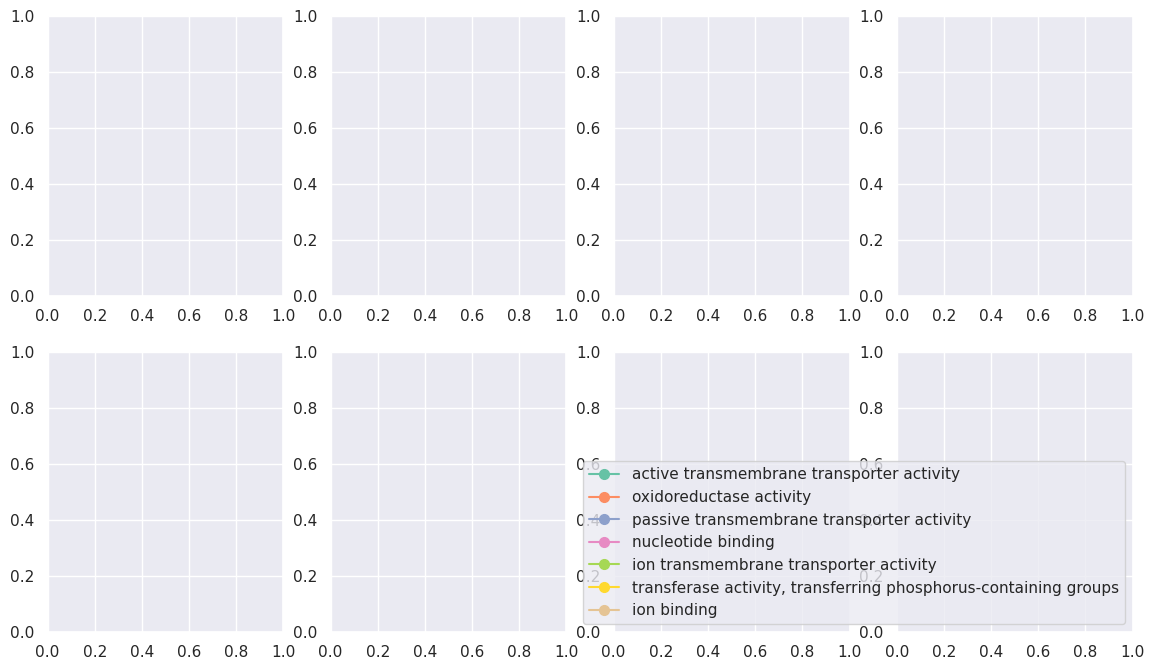

In [35]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
# axes[0, 0].scatter(rostlab_ld[r, 0], rostlab_ld[r, 1], s=0.1, alpha=1.0, c=cluster_cm(r_c / 8))
# axes[0, 0].set_title("BERT-Pretrain")
# axes[0, 1].scatter(finetune_ld[r, 0], finetune_ld[r, 1], s=0.1, alpha=1.0, c=cluster_cm(r_c / 8))
# axes[0, 1].set_title("BERT-Finetune")
# axes[0, 2].scatter(conv128_ld[r, 0], conv128_ld[r, 1], s=0.1, alpha=1.0, c=cluster_cm(r_c / 8))
# axes[0, 2].set_title("Conv128")
# axes[0, 3].scatter(label_ld[r, 0], label_ld[r, 1], s=0.1, alpha=1.0, c=cluster_cm(r_c / 8))
# axes[0, 3].set_title("Multilabel")
# for ax in axes.flatten():
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])



color_list = [cluster_cm(i / 8) for i in range(len(selected_term_names))]
from matplotlib.lines import Line2D
axes[1, 3].legend(handles=[Line2D([0], [0], marker='o', color=c, label=tn, 
                               markersize=7) for tn, c in zip(selected_term_names, color_list)], loc='lower right')
plt.show()

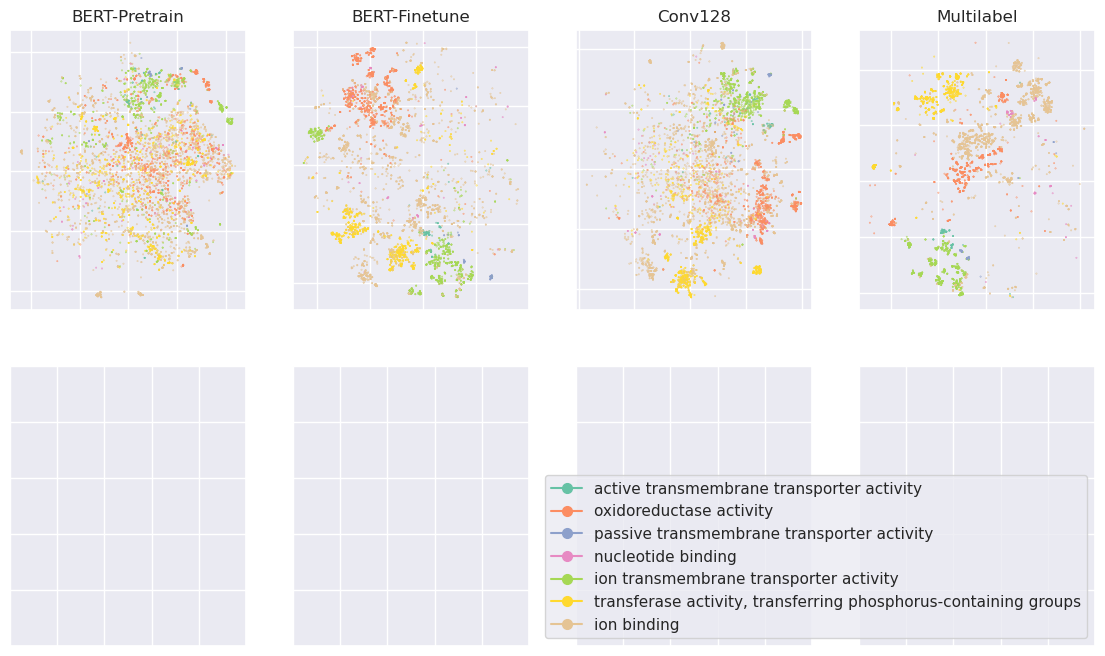

In [170]:
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
axes[0, 0].scatter(rostlab_ld[covered, 0], rostlab_ld[covered, 1], s=0.1, c=cluster_cm(r_label[covered] / 8))
axes[0, 0].set_title("BERT-Pretrain")
axes[0, 1].scatter(finetune_ld[covered, 0], finetune_ld[covered, 1], s=0.1, c=cluster_cm(r_label[covered] / 8))
axes[0, 1].set_title("BERT-Finetune")
axes[0, 2].scatter(conv128_ld[covered, 0], conv128_ld[covered, 1], s=0.1, c=cluster_cm(r_label[covered] / 8))
axes[0, 2].set_title("Conv128")
axes[0, 3].scatter(label_ld[covered, 0], label_ld[covered, 1], s=0.1, c=cluster_cm(r_label[covered] / 8))
axes[0, 3].set_title("Multilabel")
for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

from matplotlib.lines import Line2D
axes[1, 3].legend(handles=[Line2D([0], [0], marker='o', color=c, label=tn, 
                               markersize=7) for tn, c in zip(selected_term_names, color_list)], loc='lower right')
plt.show()

In [ ]:
print(lc)

NameError: name 'lc' is not defined

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']